In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,balanced_accuracy_score,f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import tree

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [3]:
seed =42

In [4]:
df = pd.read_csv("../Data/Modeling_dataset/credit_PRO.csv")

# Czyszczenie danych
Zajmujemy sie anomaliami i bledami wykrytymi podczas EDA 

usuwamy odstajace obserwacje z kolumny AMT_INCOME_TOTAL

In [5]:
data = df['AMT_INCOME_TOTAL']
print('Wejściowy rozmiar: ', data.shape[0])
upper_lim = data.quantile(.99)
df = df[( df.AMT_INCOME_TOTAL< upper_lim)]
print('Wyjściowy rozmiar: ', df.shape[0])

Wejściowy rozmiar:  14000
Wyjściowy rozmiar:  13860


-Błędne wartosci w kolumnie DAYS_EMPLOYED mozemy uzupełnić średnią
czy to dobre rozwiazanie? osoby z błędną dana maja problem ze splata w 13% czyli mniej niz w calej populacji
mozemy uzupełnić średnią i dodać dodatkową kolumnę oznaczającą błąd w danych

In [6]:
X = df.drop(["TARGET"],axis = 1)
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature engineering

- poprawienie błędnych i brakujacych wartosci
- transformacje
- skalowanie zmiennych
- wybieranie najbardziej wartosciowych kolumn
- tworzenie nowych zmiennych


## sprawdzamy jakosc kolumn numerycznych w przewidywaniu TARGET

In [7]:
target_column = "TARGET"
num_columns=['AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
df3 = df.loc[(df.DAYS_REGISTRATION!=0)&(df.DAYS_ID_PUBLISH!=0)]
df3 =df3.dropna(axis=0)
m  = -2
im= ""
jm=""
for i in num_columns:
    df3[f'{i}_category'] = pd.qcut(df3[i], q=5, labels=False, duplicates='drop')
    for j in num_columns:
        df3[f" {i} / {j}"] =df3[i]/df3[j]
df3 =df3.dropna(axis=1)
df3 =df3.drop(num_columns,axis=1)

In [8]:

Xt = df3.drop(["TARGET"],axis = 1)
yt = df3["TARGET"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.2, random_state=42, stratify=yt)

sel1 = SelectKBest(score_func=f_classif, k=10)
sel1.fit_transform(X_train_t, y_train_t)


C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 6 17 28 39 50 61 72 83 94] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array([[ 1.46402000e+05,  2.00000000e+00,  1.11880000e+00, ...,
         0.00000000e+00, -5.70545320e-01,  1.00000000e+00],
       [ 1.42309000e+05,  2.00000000e+00,  1.10560000e+00, ...,
         4.00000000e+00, -3.48312579e-01,  2.00000000e+00],
       [ 1.07008000e+05,  2.00000000e+00,  1.26400000e+00, ...,
         4.00000000e+00, -6.56158244e-01,  4.00000000e+00],
       ...,
       [ 1.44726000e+05,  2.00000000e+00,  1.52800000e+00, ...,
         2.00000000e+00, -1.52417062e+00,  0.00000000e+00],
       [ 1.00108000e+05,  2.00000000e+00,  1.21120000e+00, ...,
         3.00000000e+00, -4.08456781e-01,  4.00000000e+00],
       [ 1.35568000e+05,  2.00000000e+00,  1.00000000e+00, ...,
         3.00000000e+00, -7.71492235e-01,  1.00000000e+00]])

In [9]:
a = df3.columns.tolist()
[a[i] for i, value in enumerate(sel1.get_support()) if value]

['id',
 'FLAG_WORK_PHONE',
 ' AMT_CREDIT / AMT_ANNUITY',
 ' AMT_ANNUITY / DAYS_BIRTH',
 ' AMT_GOODS_PRICE / AMT_INCOME_TOTAL',
 ' AMT_GOODS_PRICE / AMT_CREDIT',
 ' REGION_POPULATION_RELATIVE / AMT_CREDIT',
 ' REGION_POPULATION_RELATIVE / DAYS_ID_PUBLISH',
 ' DAYS_BIRTH / AMT_CREDIT',
 ' DAYS_REGISTRATION / DAYS_ID_PUBLISH']

In [10]:
df2 = df[num_columns+["TARGET"]]
df2 = df2.dropna(axis = 0)
Xt = df2.drop(["TARGET"], axis = 1)
yt = df2["TARGET"]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.2, random_state=42, stratify=yt)

sel2 = SelectKBest(score_func=f_classif,k=5)
sel2.fit_transform(X_train_t, y_train_t)

array([[ 6.7500e+05,  4.9600e-03, -2.3053e+04, -1.0481e+04, -3.4930e+03],
       [ 2.7000e+05,  1.0276e-02, -1.2092e+04, -2.3270e+03, -4.1330e+03],
       [ 1.3500e+06,  1.8801e-02, -1.0204e+04, -4.6810e+03, -2.8650e+03],
       ...,
       [ 1.2060e+06,  2.8663e-02, -2.0629e+04, -9.2580e+03, -3.5720e+03],
       [ 6.8850e+05,  7.3300e-03, -1.0107e+04, -3.9300e+03, -2.7780e+03],
       [ 6.8850e+05,  6.2070e-03, -1.7717e+04, -9.0500e+03, -1.2550e+03]])

In [11]:
a = df2.columns.tolist()
b =[a[i] for i, value in enumerate(sel2.get_support()) if value]
b


['AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH']

## Tworzymy transformer, aby zautomatyzować preprocessing danych

In [12]:
goods_price_impute = X_train['AMT_GOODS_PRICE'].dropna().median()
days_employed_impute = df.loc[df["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
days_employed_impute

-2350.6807458803123

In [13]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, Xc, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        # modify cnt children
        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4

        # cykliczne zakodowanie zmiennej HOUR_APPR_PROCESS_START
        def sin_transformer(period):
            return FunctionTransformer(lambda x: np.sin(x/period * 2 * np.pi))
        
        def cos_transformer(period):
            return FunctionTransformer(lambda x: np.cos(x/period * 2 * np.pi))
        
        Xc['hour_sin'] = sin_transformer(24).fit_transform(Xc)['HOUR_APPR_PROCESS_START']

        # impute missing values
        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)

        # impute bad values in DAYS_EMPLOYED and add column indicating it
        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

         # stworzenie nowych zmiennych
        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT
        
        # log transforms
        Xc["AMT_CREDIT"] = np.log1p(Xc["AMT_CREDIT"])
        Xc["AMT_INCOME_TOTAL"] = np.log1p(Xc["AMT_INCOME_TOTAL"])
        Xc["AMT_ANNUITY"] = np.log1p(Xc["AMT_ANNUITY"])
        Xc["AMT_GOODS_PRICE"] = np.log1p(Xc["AMT_GOODS_PRICE"])
        Xc["DAYS_EMPLOYED"] = np.log1p(-Xc["DAYS_EMPLOYED"])
        Xc["DAYS_BIRTH"] = np.log1p(-Xc["DAYS_BIRTH"])
        Xc["DAYS_REGISTRATION"] = np.log1p(-Xc["DAYS_REGISTRATION"])
        Xc["DAYS_ID_PUBLISH"] = np.log1p(-Xc["DAYS_ID_PUBLISH"])

        # skalowanie zmiennych
        s = StandardScaler()
        Xc["AMT_CREDIT"] = s.fit_transform(Xc[["AMT_CREDIT"]])
        Xc["AMT_INCOME_TOTAL"] = s.fit_transform(Xc[["AMT_INCOME_TOTAL"]])
        Xc["AMT_ANNUITY"] = s.fit_transform(Xc[["AMT_ANNUITY"]])
        Xc["AMT_GOODS_PRICE"] = s.fit_transform(Xc[["AMT_GOODS_PRICE"]])
        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = s.fit_transform(Xc[[' AMT_CREDIT / AMT_ANNUITY']]) # tutaj przeskalowanie zmiennych znaczaca metryki modelu
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = s.fit_transform(Xc[[ ' AMT_ANNUITY / DAYS_BIRTH']])
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL']])
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_CREDIT']])

        # wybranie najlepszych kolumn,
        Xc = Xc.drop(["id"], axis=1)
        
        return Xc

wariant z one hot encoded REGION_RATING_CLIENT

In [14]:
class Transformer2(BaseEstimator, TransformerMixin):
    def fit(self, Xc, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        # modify cnt children
        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4
        
        # impute missing values
        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)

        # impute bad values in DAYS_EMPLOYED and add column indicating it
        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

         # stworzenie nowych zmiennych
        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT
        
        # log transforms
        Xc["AMT_CREDIT"] = np.log1p(Xc["AMT_CREDIT"])
        Xc["AMT_INCOME_TOTAL"] = np.log1p(Xc["AMT_INCOME_TOTAL"])
        Xc["AMT_ANNUITY"] = np.log1p(Xc["AMT_ANNUITY"])
        Xc["AMT_GOODS_PRICE"] = np.log1p(Xc["AMT_GOODS_PRICE"])
        Xc["DAYS_EMPLOYED"] = np.log1p(-Xc["DAYS_EMPLOYED"])
        Xc["DAYS_BIRTH"] = np.log1p(-Xc["DAYS_BIRTH"])
        Xc["DAYS_REGISTRATION"] = np.log1p(-Xc["DAYS_REGISTRATION"])
        Xc["DAYS_ID_PUBLISH"] = np.log1p(-Xc["DAYS_ID_PUBLISH"])

        # skalowanie zmiennych
        s = StandardScaler()
        Xc["AMT_CREDIT"] = s.fit_transform(Xc[["AMT_CREDIT"]])
        Xc["AMT_INCOME_TOTAL"] = s.fit_transform(Xc[["AMT_INCOME_TOTAL"]])
        Xc["AMT_ANNUITY"] = s.fit_transform(Xc[["AMT_ANNUITY"]])
        Xc["AMT_GOODS_PRICE"] = s.fit_transform(Xc[["AMT_GOODS_PRICE"]])
        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = s.fit_transform(Xc[[' AMT_CREDIT / AMT_ANNUITY']]) # tutaj przeskalowanie zmiennych znaczaca metryki modelu
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = s.fit_transform(Xc[[ ' AMT_ANNUITY / DAYS_BIRTH']])
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL']])
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_CREDIT']])
        
        # one hot encoding dla kolumny
        Xc = pd.get_dummies(Xc,columns= ['REGION_RATING_CLIENT'])
        # print(a)
        # Xc['RRC_1'] = a[0]
        # Xc['RRC_2'] = a[1]
        # Xc['RRC_3'] = a[2]

        # wybranie najlepszych kolumn,
        Xc = Xc.drop(["id"], axis=1)
        

        
        return Xc

## ramka danych po transformacji

In [15]:
t = Transformer()
df_transformed = t.fit_transform(df)
df_transformed

C:\Users\bartekb\AppData\Local\Temp\ipykernel_7316\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,hour_sin,BAD_DAYS_EMPLOYED,AMT_CREDIT / AMT_ANNUITY,AMT_ANNUITY / DAYS_BIRTH,AMT_GOODS_PRICE / AMT_INCOME_TOTAL,AMT_GOODS_PRICE / AMT_CREDIT
0,0,0,0.695994,1.833127,1.496305,1.866034,0.007305,9.701800,5.164786,8.917713,8.361475,1,3,14,-5.000000e-01,0,32.901022,-3.206931,7.777778,0.913209
2,1,0,-2.990627,-1.856559,-1.165754,-1.872073,0.010276,10.118599,7.762886,8.957124,8.403576,0,2,10,5.000000e-01,1,10.161580,-0.505363,3.125000,0.883392
3,1,2,0.159579,0.072904,1.541584,0.091548,0.006852,9.376448,5.111988,8.492696,8.010028,0,3,5,9.659258e-01,0,9.262735,-4.549551,2.857143,0.904486
4,0,0,-1.034884,-1.366628,-1.781673,-1.206336,0.015221,9.002947,5.049856,8.884610,6.668228,0,2,13,-2.588190e-01,0,20.000000,-1.107556,2.000000,1.000000
5,0,0,1.310035,-0.069237,0.780875,0.091548,0.046220,9.575331,4.770685,6.421622,7.640123,0,1,16,-8.660254e-01,0,12.610340,-2.477437,1.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0,0,-1.034884,0.302249,-0.391767,0.463176,0.016612,9.178230,7.622175,7.534228,7.707512,1,2,12,1.224647e-16,0,30.791094,-1.962099,6.500000,1.000000
13996,0,0,1.310035,0.663815,0.814124,0.665872,0.018850,9.547027,6.318968,5.501258,8.427706,0,2,15,-7.071068e-01,0,20.787811,-2.594522,2.500000,0.893815
13997,1,0,0.695994,1.071150,0.990113,1.073362,0.026392,9.521568,8.234830,8.927447,8.227108,1,2,20,-8.660254e-01,0,25.215236,-2.925495,4.444444,0.893815
13998,0,0,-1.034884,-0.915725,-1.189280,-0.755261,0.007330,9.483112,6.965080,8.856803,8.067776,0,2,13,-2.588190e-01,0,20.000000,-0.942139,2.750000,1.000000


# Pierwszy model i baseline

In [16]:
pipeline = Pipeline([
    ('transformer', Transformer()),
    ("estimator", LogisticRegression(penalty='l2',random_state=seed))
])

In [17]:
pipeline.fit(X_train,y_train)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_7316\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer', Transformer()),
                ('estimator', LogisticRegression(random_state=42))])

In [18]:
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[2275    1]
 [ 496    0]]
Balanced Accuracy: 0.49978031634446396
Accuracy: 0.8207070707070707


C:\Users\bartekb\AppData\Local\Temp\ipykernel_7316\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


C:\Users\bartekb\AppData\Local\Temp\ipykernel_7316\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


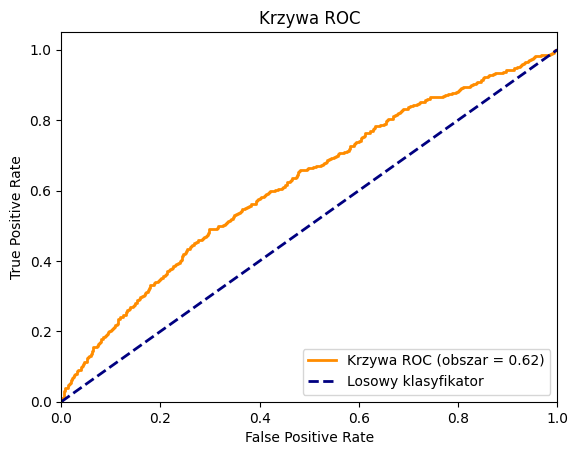

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

- baseline_acc = 0.82
- baseline_balance_acc = 0.5

# Oversampling

## XGBClassifier

In [31]:
pipeline1 = ImbPipeline([
    
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('transformer', Transformer(), X_train.columns),
        ],
        remainder='passthrough'
    )),
    ('oversampler', SMOTE(random_state= seed)),
    ("estimator", XGBClassifier(penalty ="l2",random_state = seed))
])

In [32]:
pipeline1.fit(X_train,y_train)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_7316\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:160: UserWarning: [13:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "penalty" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer', Transformer(),
                                                  Index(['id', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'HOUR...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, penalty='l2', ...))])

In [33]:
y_pred = pipeline1.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
scr = f1_score(y_test,y_pred)
print(scr)

Confusion Matrix:
[[1991  285]
 [ 381  115]]
Balanced Accuracy: 0.5533175775270707
Accuracy: 0.7597402597402597


C:\Users\bartekb\AppData\Local\Temp\ipykernel_7316\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


TypeError: 'numpy.float64' object is not callable

In [211]:
# conf_matrix[0,0]*m-conf_matrix[1,0]*m

C:\Users\bartekb\AppData\Local\Temp\ipykernel_13932\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


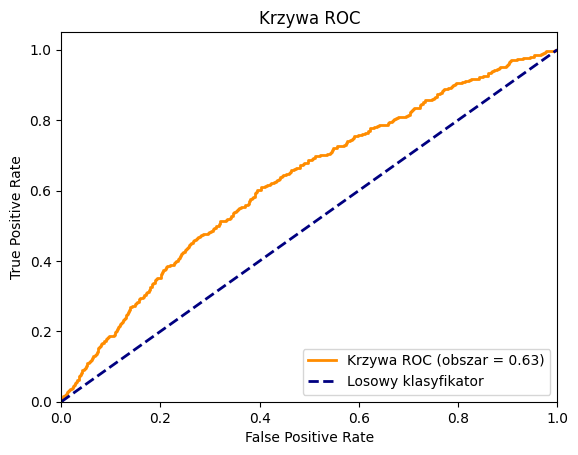

In [231]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test,pipeline1.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()


## SVC

In [232]:
pipeline1 = ImbPipeline([
    
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('transformer', Transformer(), X_train.columns),
        ],
        remainder='passthrough'
    )),
    ('oversampler', SMOTE(random_state=seed)),
    ("estimator", SVC(random_state=seed))
])

In [234]:
pipeline1.fit(X_train,y_train)
y_pred = pipeline1.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_13932\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\bartekb\AppData\Local\Temp\ipykernel_13932\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[1486  790]
 [ 226  270]]
Balanced Accuracy: 0.5986273314813765
Accuracy: 0.6334776334776335


## Decision Tree Classifier

In [237]:
pipeline1 = ImbPipeline([
    
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('transformer', Transformer(), X_train.columns),
        ],
        remainder='passthrough'
    )),
    ('oversampler', SMOTE(random_state=seed)),
    ("estimator", tree.DecisionTreeClassifier(random_state=seed))])

In [238]:
pipeline1.fit(X_train,y_train)
y_pred = pipeline1.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_13932\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Confusion Matrix:
[[1697  579]
 [ 325  171]]
Balanced Accuracy: 0.5451821957027042
Accuracy: 0.6738816738816739


C:\Users\bartekb\AppData\Local\Temp\ipykernel_13932\1206679004.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


Dalsze pomysły:
- ocena modelu przy uzyciu customowej metryki z użyciem AMT_CREDIT